In [1]:
import numpy as np, matplotlib.pyplot as plt, os
import matplotlib.gridspec as gridspec

from glob import glob
from tqdm import tqdm

import tools21cm as t2c

In [2]:
from matplotlib import colors
import matplotlib.pyplot as plt
import math

class MidpointNormalize(colors.Normalize):
    """
    Created by Joe Kington.
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    # set the colormap and centre the colorbar
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

class adjust_axis:
    def __init__(self, axis, varr, xy, to_round=10, step=5, fmt=int):
        self.axis = axis
        self.varr = varr
        self.to_round = to_round
        self.step = step
        self.fmt = fmt
        
        ord_magn = math.floor(math.log10(step))
        loc_f, vplot = self.get_axis_locs(ord_magn)
        print(loc_f)
        if(xy == 'x'):
            plt.xticks(loc_f)
            axis.set_xticklabels(vplot)
        elif(xy == 'y'):
            plt.yticks(loc_f)
            axis.set_yticklabels(vplot)
        elif(xy == 'xy'):
            plt.xticks(loc_f)
            axis.set_xticklabels(vplot)
            plt.yticks(loc_f)
            axis.set_yticklabels(vplot)
        
    def get_axis_locs(self, ord_magn):    
        if(ord_magn<0):
            v_max = int(round(self.varr.max()/self.to_round)*self.to_round) if int(round(self.varr.max()/self.to_round)*self.to_round) <= self.varr.max() else int(round(self.varr.max()/self.to_round)*self.to_round)-self.to_round
            v_min = int(round(self.varr.min()/self.to_round)*self.to_round) if int(round(self.varr.min()/self.to_round)*self.to_round) >= self.varr.min() else int(round(self.varr.min()/self.to_round)*self.to_round)+self.to_round
            v_plot = np.arange(v_min, v_max+self.step, self.step)
        else:
            v_max = int(self.to_round)
            v_min = 0
            v_plot = np.arange(v_min, v_max, self.step)
        print(v_plot)
        loc_v = np.array([np.argmin(abs(self.varr-v_plot[i])) for i in range(v_plot.size)]).astype(self.fmt)

        return loc_v, v_plot 

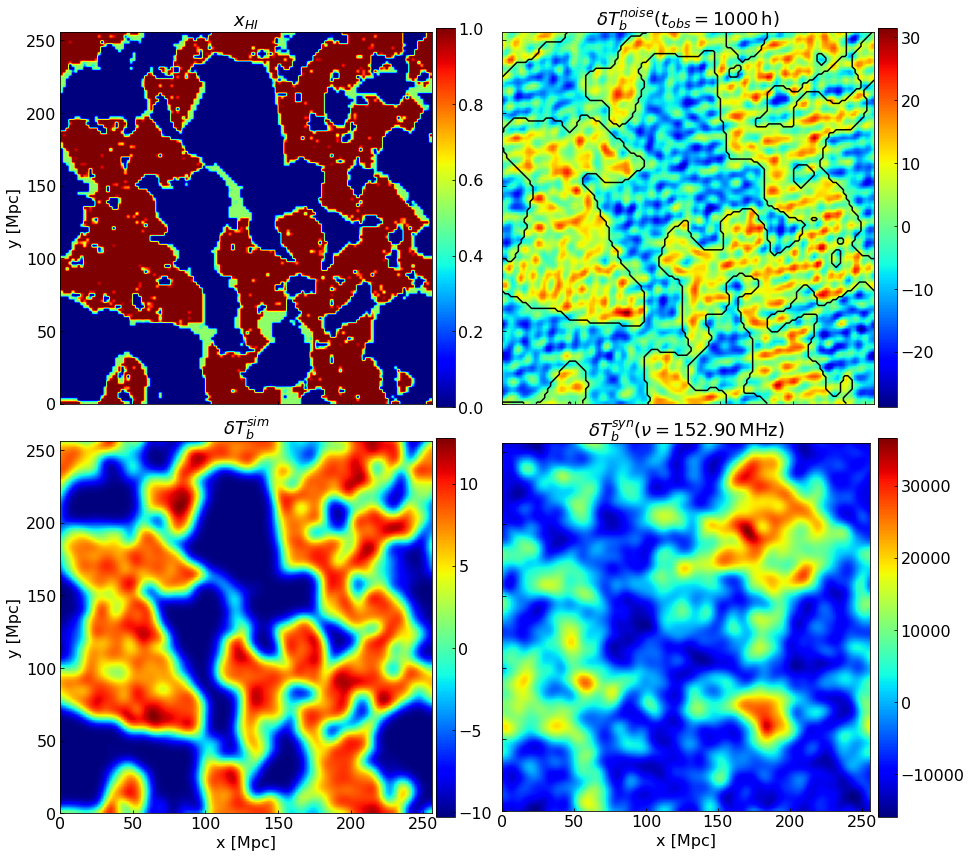

In [138]:
i = 0
path_input = '/scratch/snx3000/mibianco/dataLC_128_train_190922/'
my_ext = [0, 256, 0, 256]

mask_xH = t2c.read_cbin('%sdata/xH_21cm_i%d.bin' %(path_input, i))
xHI = t2c.read_cbin('%sdata/xHI_21cm_i%d.bin' %(path_input, i))
dT = t2c.read_cbin('%sdata/dT_21cm_i%d.bin' %(path_input, i))
dT2 = t2c.read_cbin('%sdata/dT2_21cm_i%d.bin' %(path_input, i))
dT3 = t2c.read_cbin('%sdata/dT3_21cm_i%d.bin' %(path_input, i))
dT4 = t2c.read_cbin('%sdata/dT4_21cm_i%d.bin' %(path_input, i))
redshift = np.loadtxt(path_input+'lc_redshifts.txt')

i_slice = np.argmin(abs(np.mean(mask_xH, axis=(0,1)) - 0.5))
nu = t2c.z_to_nu(redshift[i_slice])

fig, axs = plt.subplots(2, 2, figsize=(15,15))
for ax in axs.flat: ax.label_outer()

#fig.suptitle('z = %.3f\t\t$x^v_{HI}$ = %.2f\n$\zeta$ = %.3f        $R_{mfp}$ = %.3f Mpc        $log_{10}(T_{vir}^{min})$ = %.3f' %(z, np.mean(xH), zeta, Rmfp, Tvir), fontsize=18)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 16

axs[0,0].set_title('$x_{HI}$', size=18)
#axs[0,0].contour(mask_xH[...,i_slice], colors='lime', levels=[0.5], extent=my_ext)
im = axs[0,0].imshow(xHI[...,i_slice], origin='lower', cmap='jet', extent=my_ext)
fig.colorbar(im, ax=axs[0,0], pad=0.01, fraction=0.048)
axs[0,0].set_ylabel('y [Mpc]');

axs[0,1].set_title(r'$\delta T^{noise}_b(t_{obs}=1000\,\rm{h})$', size=18)
axs[0,1].contour(mask_xH[...,i_slice], colors='black', levels=[0.5], extent=my_ext)
im = axs[0,1].imshow(dT3[...,i_slice], origin='lower', cmap='jet', extent=my_ext)
fig.colorbar(im, ax=axs[0,1], pad=0.01, fraction=0.048)

axs[1,0].set_title('$\delta T^{sim}_b$', size=18)
im = axs[1,0].imshow(dT2[...,i_slice], origin='lower', cmap='jet', extent=my_ext)
axs[1,0].set_xlabel('x [Mpc]'), axs[1,0].set_ylabel('y [Mpc]');
fig.colorbar(im, ax=axs[1,0], pad=0.01, fraction=0.048)

axs[1,1].set_title(r'$\delta T^{syn}_b(\nu=%.2f\,\rm{MHz})$' %nu, size=18)
im = axs[1,1].imshow(dT4[...,i_slice], origin='lower', cmap='jet', extent=my_ext)
#axs[1,1].contour(mask_xH[...,i_slice], colors='k', levels=[0.5], extent=my_ext)
axs[1,1].set_xlabel('x [Mpc]')
fig.colorbar(im, ax=axs[1,1], pad=0.02, fraction=0.048)

plt.subplots_adjust(hspace=0.01, wspace=0.12)
plt.savefig('/scratch/snx3000/mibianco/example_dataset.png', bbox_inches='tight', facecolor='white')

-18.49012 23.970928 -4.4703484e-08 5.796811
-18.775335 21.555996 1.4901161e-08 5.438146


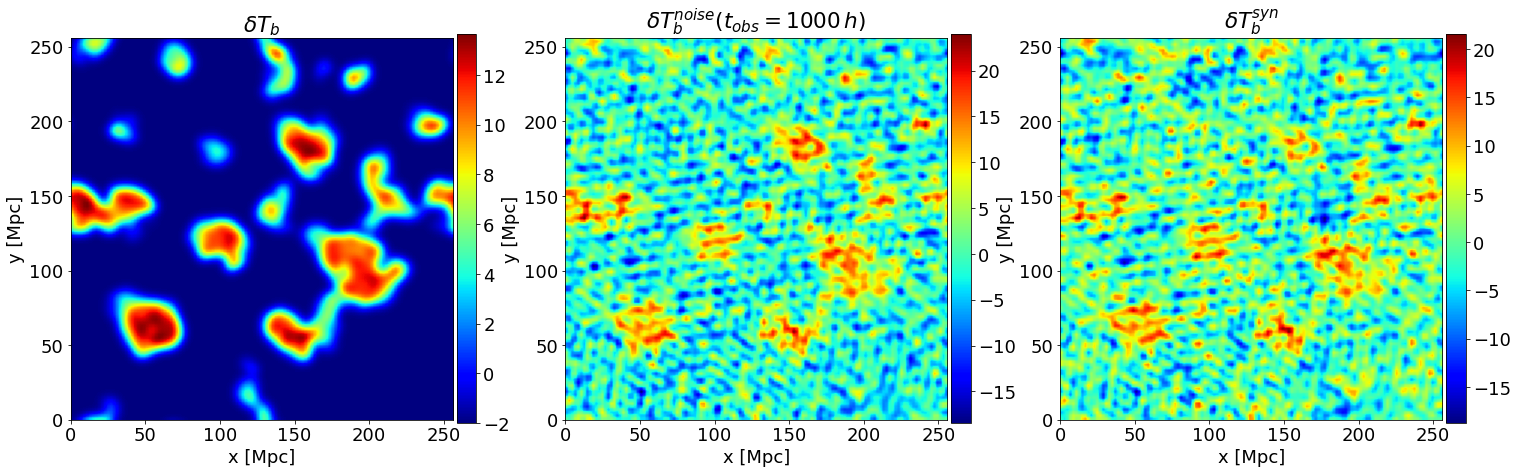

In [76]:
from matplotlib.colors import LogNorm
plt.rcParams['font.size'] = 18

i = 0
path_input = '/scratch/snx3000/mibianco/dataLC_128_valid_190922/'

mask_xH = t2c.read_cbin('%sdata/xH_21cm_i%d.bin' %(path_input, i))
dT2 = t2c.read_cbin('%sdata/dT2_21cm_i%d.bin' %(path_input, i))
dT3 = t2c.read_cbin('%sdata/dT3_21cm_i%d.bin' %(path_input, i))
dT4 = t2c.read_cbin('%sdata/dT4pca_21cm_i%d.bin' %(path_input, i))

i_slice = np.argmin(abs(np.mean(mask_xH, axis=(0,1)) - 0.1))
my_ext = [0, 256, 0, 256]
fig, axs = plt.subplots(1, 3, figsize=(25,15))
axs[0].set_title(r'$\delta T_b$')
im = axs[0].imshow(dT2[..., i_slice], origin='lower', cmap='jet', extent=my_ext, vmin=dT2[..., i_slice].min(), vmax=dT2[..., i_slice].max())
#fig.colorbar(im, ax=axs[0], label=r'$\delta T_b$ [mK]', pad=0.01, fraction=0.048)
fig.colorbar(im, ax=axs[0], pad=0.01, fraction=0.048)
axs[1].set_title(r'$\delta T^{noise}_b(t_{obs}=1000\,h)$')
im = axs[1].imshow(dT3[..., i_slice], origin='lower', cmap='jet', extent=my_ext, vmin=dT3[..., i_slice].min(), vmax=dT3[..., i_slice].max())
print(dT3[..., i_slice].min(), dT3[..., i_slice].max(), dT3[..., i_slice].mean(), dT3[..., i_slice].std())
fig.colorbar(im, ax=axs[1], pad=0.01, fraction=0.048)
#fig.colorbar(im, ax=axs[1], label=r'$\delta T^{noise}_b$ [mK]', pad=0.01, fraction=0.048)
axs[2].set_title(r'$\delta T^{syn}_b$')
im = axs[2].imshow(dT4[..., i_slice], origin='lower', cmap='jet', extent=my_ext, vmin=dT4[..., i_slice].min(), vmax=dT4[..., i_slice].max())
print(dT4[..., i_slice].min(), dT4[..., i_slice].max(), dT4[..., i_slice].mean(), dT4[..., i_slice].std())
#fig.colorbar(im, ax=axs[2], label=r'$\delta T^{syn}_b$ [mK]', pad=0.01, fraction=0.048)
fig.colorbar(im, ax=axs[2], pad=0.01, fraction=0.048)

for ax in axs:
    ax.set_xlabel('x [Mpc]', size=18)
    ax.set_ylabel('y [Mpc]', size=18)

plt.subplots_adjust(hspace=0.1, wspace=0.22)
plt.savefig('/scratch/snx3000/mibianco/example_dataset.png', bbox_inches='tight', facecolor='white')

In [59]:
i = 10
path_input = '/scratch/snx3000/mibianco/dataLC_128_pred_190922/'
redshift = np.loadtxt(path_input+'lc_redshifts.txt')
data = t2c.read_cbin('%sdata/dT2_21cm_i%d.bin' %(path_input, i))
true = t2c.read_cbin('%sdata/xH_21cm_i%d.bin' %(path_input, i))
data2, _ = t2c.smooth_lightcone(data, z_array=redshift, box_size_mpc=256.)

plt.imshow(data[:,64,:])
plt.contour(true[:,64,:])
plt.show(), plt.clf()

print(np.mean(data[...,0]), np.mean(data[...,-1]))
plt.imshow(data2[...,0])
plt.contour(true[...,0])
plt.show(), plt.clf()

FileNotFoundError: /scratch/snx3000/mibianco/dataLC_128_pred_190922/lc_redshifts.txt not found.

In [57]:
mean_xHI = true.mean(axis=(0,1))
plot_mean = np.arange(0., 1.1, 0.1)
#print(plot_mean)

xHI_plot = np.arange(0.1, 1., 0.1)
redshift_plot = np.array([redshift[np.argmin(abs(mean_xHI - meanHI))] for meanHI in xHI_plot])
print(redshift_plot)

[ 7.83593  8.25364  8.55339  8.7016   9.07621  8.90463  9.31459  9.72556
 10.20573]


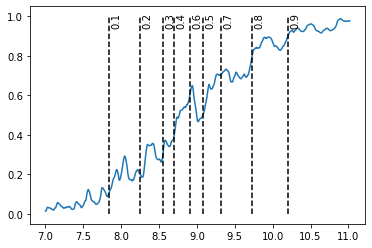

In [58]:
plt.plot(redshift, mean_xHI)
plt.vlines(redshift_plot, ymin=0, ymax=1, color='black', ls='--')

#plt.text(redshift_plot, np.ones_like(redshift_plot), np.arange(0., 1.1, 0.1))
#
for iplot in range(redshift_plot.size):
    plt.text(redshift_plot[iplot]+0.03, 0.95, round(xHI_plot[iplot],1), rotation=90)


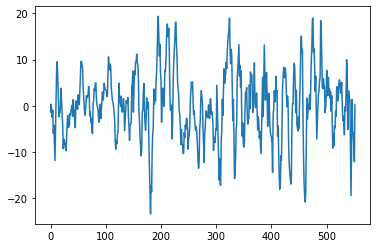

In [147]:
pixel = data[0,0]
plt.plot(pixel)

In [15]:
path_input = '/store/ska/sk09/segunet/inputs/dataLC_128_pred_310822/'

good_data, bad_data = [], []
for i in tqdm(range(300)):
    xHI = t2c.read_cbin('%sdata/xHI_21cm_i%d.bin' %(path_input, i))
    min_xH = np.mean(xHI[..., 0])
    max_xH = np.mean(xHI[..., -1])
    if(min_xH <= 0.1 and max_xH >= 0.9):
        good_data.append(i)
    else:
        bad_data.append(i)
        
bad_data = np.array(bad_data)
good_data = np.array(good_data)

100%|██████████| 300/300 [01:41<00:00,  2.97it/s]


In [16]:
print(good_data.size/300, bad_data.size/300)

0.03666666666666667 0.9633333333333334


In [17]:
np.savetxt('/scratch/snx3000/mibianco/good_data.txt', good_data, fmt='%d')

In [72]:
min_xH = np.empty(10000)
max_xH = np.empty(10000)

path_input = '/store/ska/sk09/segunet/inppath_inputdataLC_128_train_310822/'

for i in tqdm(range(10000)):
    xHI = t2c.read_cbin('%sdata/xHI_21cm_i%d.bin' %(path_input, i))
    min_xH[i] = np.mean(xHI[..., 0])
    max_xH[i] = np.mean(xHI[..., -1])

idx = np.arange(10000)
mask = (min_xH < 0.1) * (max_xH > 0.9)
good_data = idx[mask]

100%|██████████| 10000/10000 [50:26<00:00,  3.30it/s]  


In [79]:
good_data.size

269

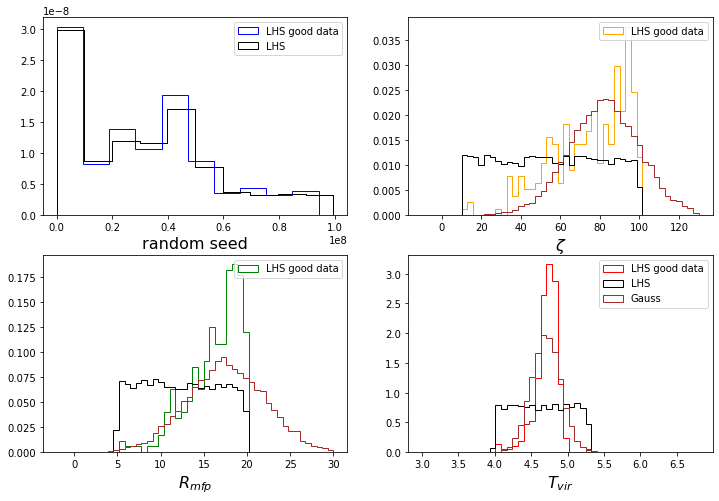

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [105]:
import random

astro_params = np.loadtxt(path_input+'parameters/astro_params.txt')
idx, eff_fact_lhs, Rmfp_lhs, Tvir_lhs, rseed_lhs = astro_params.T

astro_params = np.loadtxt(path_input+'parameters/astro_params.txt')[good_data]
idx, eff_fact, Rmfp, Tvir, rseed = astro_params.T

eff_fact_gauss = [random.gauss(82., 18.) for i in range(10000)]
Rmfp_gauss = [random.gauss(17.5, 4.5) for i in range(10000)]
Tvir_gauss = [random.gauss(4.7, 0.2) for i in range(10000)]

fig, axs = plt.subplots(2, 2, figsize=(12,8))
# dataset
axs[0,0].hist(rseed, density=True, histtype='step', color='blue', label='LHS good data');
axs[0,1].hist(eff_fact, np.linspace(-10,130), density=True, histtype='step', color='orange', label='LHS good data');
axs[1,0].hist(Rmfp, np.linspace(-2,30), density=True, histtype='step', color='green', label='LHS good data');
axs[1,1].hist(Tvir, np.linspace(3,6.8), density=True, histtype='step', color='red', label='LHS good data');
axs[0,0].set_xlabel(r'random seed', size=16)
axs[0,1].set_xlabel(r'$\zeta$', size=16)
axs[1,0].set_xlabel(r'$R_{mfp}$', size=16)
axs[1,1].set_xlabel(r'$T_{vir}$', size=16);
#LHS
axs[0,0].hist(rseed_lhs, density=True, histtype='step', color='black', label='LHS');
axs[0,1].hist(eff_fact_lhs, np.linspace(-10,130), density=True, histtype='step', color='black');
axs[1,0].hist(Rmfp_lhs, np.linspace(-2,30), density=True, histtype='step', color='black');
axs[1,1].hist(Tvir_lhs, np.linspace(3,6.8), density=True, histtype='step', color='black', label='LHS');
#Gaussian
axs[0,0].hist(rseed_lhs, density=True, histtype='step', color='black');
axs[0,1].hist(eff_fact_gauss, np.linspace(-10,130), density=True, histtype='step', color='brown');
axs[1,0].hist(Rmfp_gauss, np.linspace(-2,30), density=True, histtype='step', color='brown');
axs[1,1].hist(Tvir_gauss, np.linspace(3,6.8), density=True, histtype='step', color='brown', label='Gauss');

for ax in axs.flatten():
    ax.legend()
plt.savefig('/scratch/snx3000/mibianco/astro_params_stat.png', bbox_inches='tight', facecolor='white'), plt.show(), plt.clf()

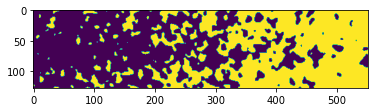

In [47]:
i = 269
path_input = '/store/ska/sk09/segunet/inputs/dataLC_128_pred_310822/'
data = t2c.read_cbin('%sdata/xH_21cm_i%d.bin' %(path_input, i))

plt.imshow(data[:,64,:])

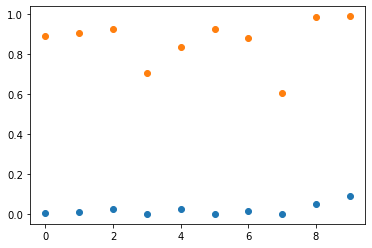

(None, None)

<Figure size 432x288 with 0 Axes>

In [37]:
plt.scatter(np.arange(min_plot.size)[:10], min_plot[:10], color='tab:blue')
plt.scatter(np.arange(min_plot.size)[:10], max_plot[:10], color='tab:orange')
plt.show(), plt.clf()
#H = plt.hist(x=min_xH, histtype='step')
#H = plt.hist(x=max_xH, histtype='step')

In [26]:
i_plot = 100
path_input = '/store/ska/sk09/segunet/inputs/dataLC_128_pred_310822/'

dT = t2c.read_cbin('%sdata/dT_21cm_i%d.bin' %(path_input, i_plot))
target = t2c.read_cbin('%sdata/dT2_21cm_i%d.bin' %(path_input, i_plot))
mask_xH = t2c.read_cbin('%sdata/xH_21cm_i%d.bin' %(path_input, i_plot))
data = t2c.read_cbin('%sdata/dT4pca_21cm_i%d.bin' %(path_input, i_plot))
target = t2c.read_cbin('%sdata/xH_21cm_i%d.bin' %(path_input, i_plot))
redshift = np.loadtxt(path_input+'lc_redshifts.txt')

<function IndependentOperation_LC.<locals>.<lambda> at 0x155422ed9090> 2 0


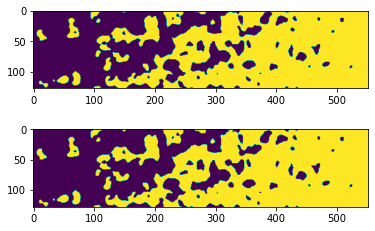

<Figure size 432x288 with 0 Axes>

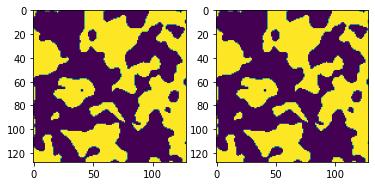

(None, None)

<Figure size 432x288 with 0 Axes>

In [95]:
def IndependentOperation_LC():
    operations = [lambda a: a, np.fliplr, np.flipud, lambda a: np.flipud(np.fliplr(a))] 
    axis = [2] 
    angl_rot = [0,1,2,3] 
    
    permut_op = {} 
    i = 0 
    for iopt, opt in enumerate(operations): 
        for rotax in axis: 
            for rot in angl_rot: 
                permut_op['opt%d' %i] = [opt, rotax, rot] 
                i += 1
    return permut_op


transf_opts = IndependentOperation_LC()
iopt = 0
opt, rotax, rot = transf_opts['opt%d' %iopt]
print(opt, rotax, rot)
ax_tup = [0,1,2] 
ax_tup.remove(rotax)

#test_roll = np.roll(mask_xH, shift=64, axis=0)
test_roll = opt(mask_xH)
test_roll = np.rot90(opt(mask_xH), k=rot, axes=ax_tup) 

fig, axs = plt.subplots(nrows=2, ncols=1)
axs[0].imshow(test_roll[:, 64, :])
axs[1].imshow(mask_xH[:, 64, :])
plt.show(), plt.clf()

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(test_roll[...,200])
axs[1].imshow(mask_xH[...,200])
plt.show(), plt.clf()

In [94]:
transf_opts = IndependentOperation_LC()
transf_opts['opt0']
for iopt in range(len(transf_opts['opt0'])):
    print(iopt)

0
1
2


7.0 6.8860965 3.759936431515595
-1.9548750596147555 2.671753670939264


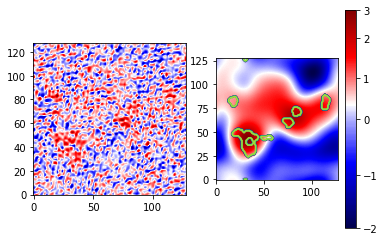

In [22]:
i = 0

in_datatest = data[...,i]
std_datatest = np.std(in_datatest)
fwhm = (1+redshift[i])*21e-5/2. * t2c.z_to_cdist(redshift[i]) * 128/256.

print(redshift[i], std_datatest, fwhm)
datatest = t2c.smooth_gauss(input_array=in_datatest, fwhm=fwhm*redshift[i])

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(in_datatest, cmap='seismic', origin='lower', norm=MidpointNormalize(vmax=in_datatest.max(), vmin=in_datatest.min(), midpoint=0))
ax1.contour(mask_xH[...,i], color='lime')
im = ax1.imshow(datatest, cmap='seismic', origin='lower', norm=MidpointNormalize(vmax=datatest.max(), vmin=datatest.min(), midpoint=0))
fig.colorbar(im, ax=ax1)
print(datatest.min(), datatest.max())

In [12]:
data2, _ = t2c.smooth_lightcone(data, z_array=redshift, box_size_mpc=256.)

100%|██████████| 552/552 [00:00<00:00, 929.72it/s]


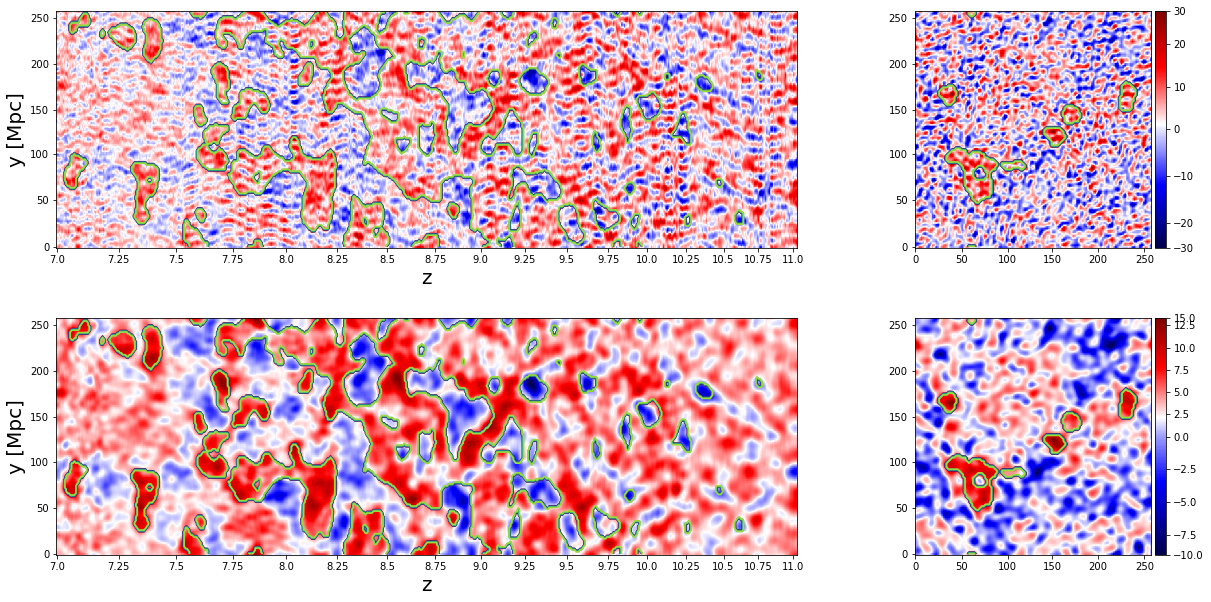

In [15]:
i_slice, i_lc = np.argmin(abs(mask_xH - 0.5)), 64

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[2,1])#, height_ratios=[1,1])

# FIRST LC PLOT
ax0 = fig.add_subplot(gs[0,0])
im = ax0.imshow(data[:,i_lc,:], cmap='seismic', aspect='auto', origin='lower')
ax0.contour(target[:,i_lc,:])
adjust_axis(varr=redshift, xy='x', axis=ax0, to_round=1, step=0.25)
adjust_axis(varr=np.linspace(0, 256, 128), xy='y', axis=ax0, to_round=256, step=50)
ax0.set_ylabel('y [Mpc]', size=20)
ax0.set_xlabel('z', size=20)

# FIRST SLICE PLOT
ax01 = fig.add_subplot(gs[0,1])
im = ax01.imshow(data[...,i_slice], cmap='seismic', origin='lower', norm=MidpointNormalize(vmax=data[...,i_slice].max(), vmin=data[...,i_slice].min(), midpoint=0))
ax01.contour(target[...,i_slice])
adjust_axis(varr=np.linspace(0, 256, 128), xy='xy', axis=ax01, to_round=256, step=50)
fig.colorbar(im, ax=ax01, pad=0.01, fraction=0.048)

# SECOND LC PLOT
ax1 = fig.add_subplot(gs[1,0])
im = ax1.imshow(data2[:,i_lc,:], cmap='seismic', aspect='auto', origin='lower')
ax1.contour(target[:,i_lc,:])
adjust_axis(varr=redshift, xy='x', axis=ax1, to_round=1, step=0.25)
adjust_axis(varr=np.linspace(0, 256, 128), xy='y', axis=ax1, to_round=256, step=50)
ax1.set_ylabel('y [Mpc]', size=20)
ax1.set_xlabel('z', size=20)

# SECOND SLICE PLOT
ax11 = fig.add_subplot(gs[1,1])
im = ax11.imshow(data2[...,i_slice], cmap='seismic', origin='lower', norm=MidpointNormalize(vmax=data2[...,i_slice].max(), vmin=data2[...,i_slice].min(), midpoint=0))
ax11.contour(target[...,i_slice])
adjust_axis(varr=np.linspace(0, 256, 128), xy='xy', axis=ax11, to_round=256, step=50)
fig.colorbar(im, ax=ax11, pad=0.01, fraction=0.048)

"""
for ax in ax01:
    ax.set_ylabel('y [Mpc]', size=20)
    ax.set_xlabel('x [Mpc]', size=20)
"""

plt.subplots_adjust(hspace=0.3, wspace=0.01)
#plt.savefig('%svisual_comparison_lc.png' %path_out, bbox_inches='tight')

In [56]:
mean_dT = np.mean(dT, axis=(0,1))
std_dT = np.std(dT, axis=(0,1))

mean_data = np.mean(data2, axis=(0,1))
std_data = np.std(data2, axis=(0,1))

mean_xH = np.mean(mask_xH, axis=(0,1))
std_xH = np.std(mask_xH, axis=(0,1))

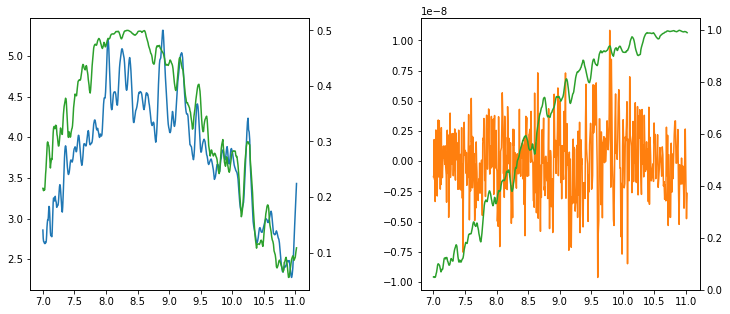

<Figure size 432x288 with 0 Axes>

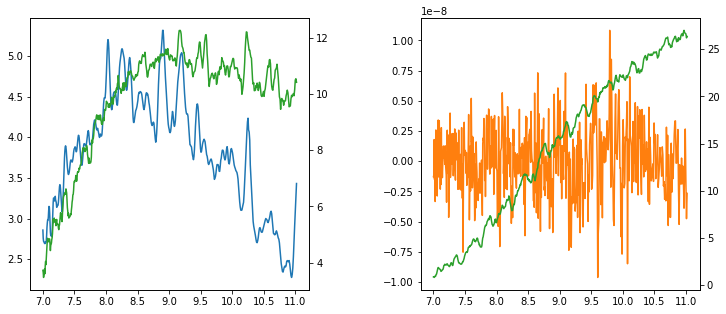

(None, None)

<Figure size 432x288 with 0 Axes>

In [57]:
fig, axs = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
axs[0].plot(redshift, std_data, color='tab:blue')
ax0 = axs[0].twinx()
ax0.plot(redshift, std_xH, color='tab:green')
ax0.set_xlabel('z')

axs[1].plot(redshift, mean_data, color='tab:orange')
ax1 = axs[1].twinx()
ax1.plot(redshift, mean_xH, color='tab:green')
ax1.set_xlabel('z')

plt.subplots_adjust(wspace=0.4)
plt.show(), plt.clf()


fig, axs = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
axs[0].plot(redshift, std_data, color='tab:blue')
ax0 = axs[0].twinx()
ax0.plot(redshift, std_dT, color='tab:green')
ax0.set_xlabel('z')

axs[1].plot(redshift, mean_data, color='tab:orange')
ax1 = axs[1].twinx()
ax1.plot(redshift, mean_dT, color='tab:green')
ax1.set_xlabel('z')

plt.subplots_adjust(wspace=0.4)
plt.show(), plt.clf()

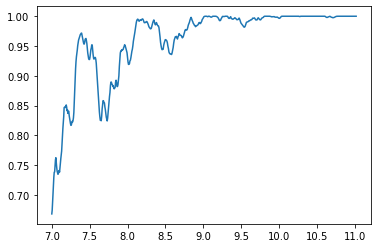

(None, None)

<Figure size 432x288 with 0 Axes>

In [205]:
plt.plot(redshift, mean_xH)
plt.show(), plt.clf()

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

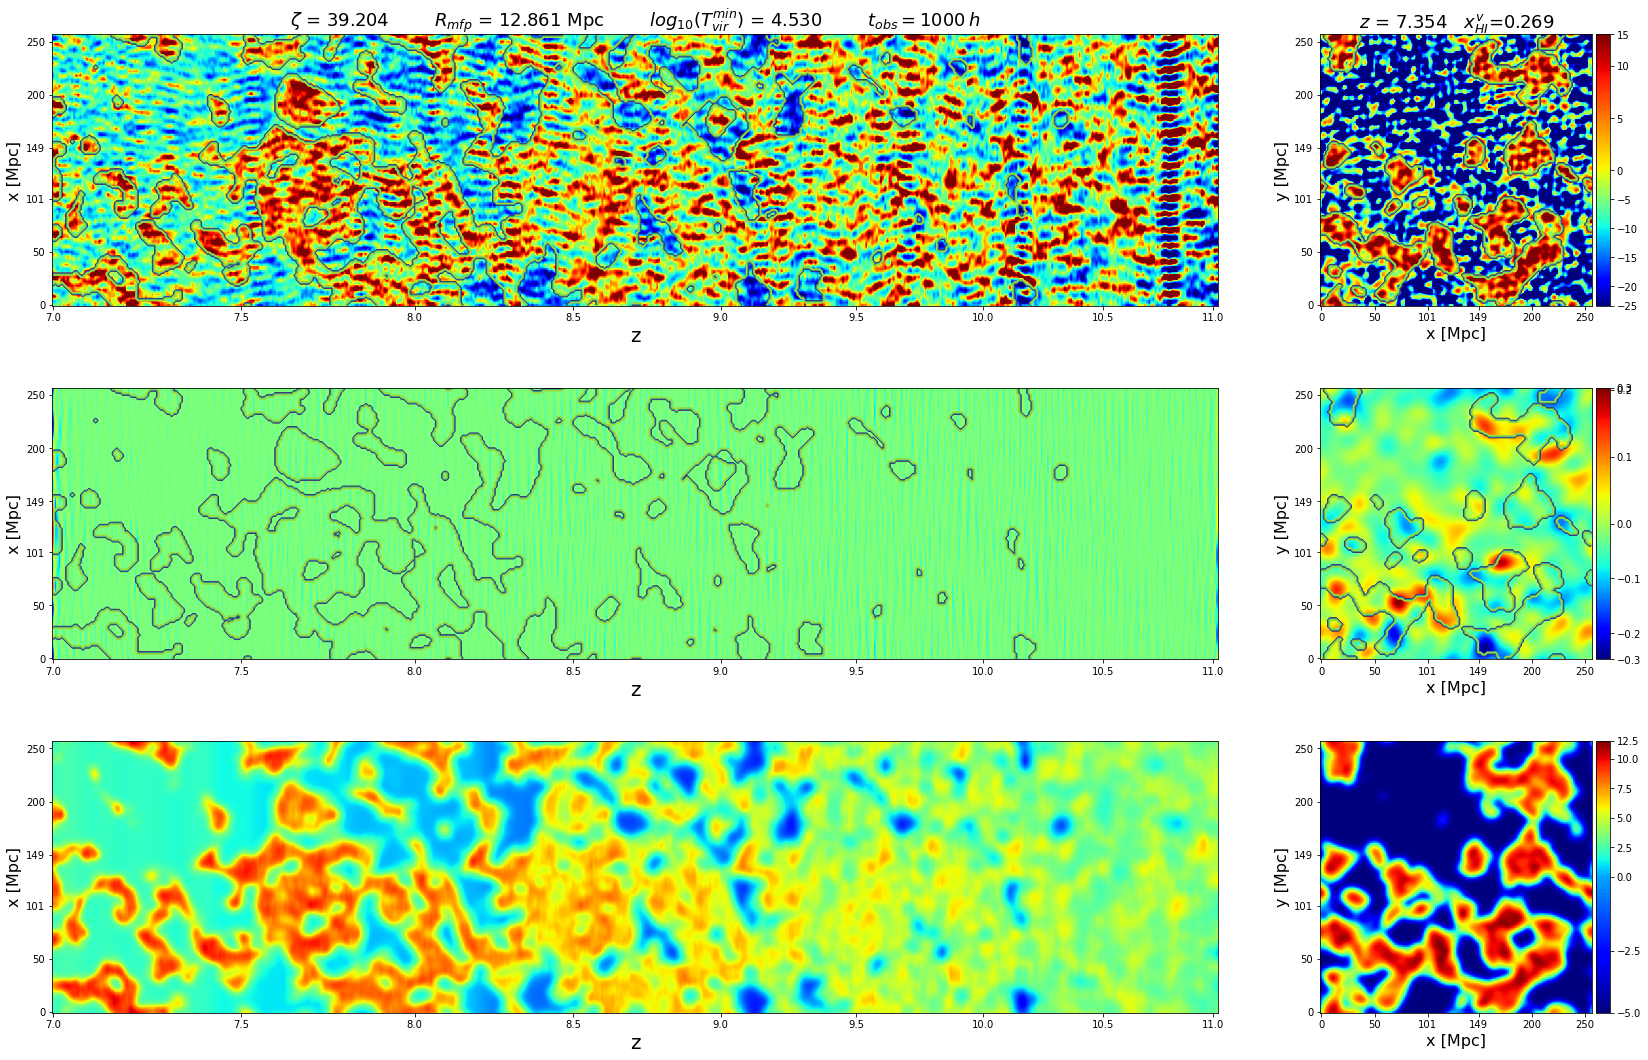

In [15]:
i_plot=64

fig = plt.figure(figsize=(28, 18))
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[3,1], height_ratios=[1, 1, 1])

# FIRST LC PLOT
ax0 = fig.add_subplot(gs[0,0])
ax0.set_title('$\zeta$ = %.3f        $R_{mfp}$ = %.3f Mpc        $log_{10}(T_{vir}^{min})$ = %.3f        $t_{obs}=%d\,h$' %(zeta, Rmfp, Tvir, tobs), fontsize=18)
im = ax0.imshow(dT3[:,params['HII_DIM']//2,:], cmap='jet', aspect='auto', origin='lower', norm=MidpointNormalize(vmin=dT2.min(), vmax=dT2.max(), midpoint=0))
ax0.contour(mask_xH[:,params['HII_DIM']//2,:])
adjust_axis(axis=ax0, varr=redshifts, xy='x', to_round=1, step=0.5, fmt=int)
adjust_axis(axis=ax0, varr=np.linspace(0, params['BOX_LEN'], params['HII_DIM']), xy='y', to_round=250, step=50, fmt=int)

ax01 = fig.add_subplot(gs[0,1])
ax01.set_title('$z$ = %.3f   $x^v_{HI}$=%.3f' %(redshifts[i_plot], np.mean(xHI[:,:,i_plot])), fontsize=18)
ax01.imshow(dT3[:,:,i_plot], cmap='jet', origin='lower', norm=MidpointNormalize(vmin=dT2[:,:,i_plot].min(), vmax=dT2[:,:,i_plot].max(), midpoint=0))
ax01.contour(mask_xH[:,:,i_plot])
adjust_axis(axis=ax01, varr=np.linspace(0, params['BOX_LEN'], params['HII_DIM']), xy='x', to_round=250, step=50, fmt=int)
adjust_axis(axis=ax01, varr=np.linspace(0, params['BOX_LEN'], params['HII_DIM']), xy='y', to_round=250, step=50, fmt=int)
fig.colorbar(im, ax=ax01, pad=0.01, fraction=0.048)

# SECOND LC PLOT
ax1 = fig.add_subplot(gs[1,0])
#ax1.imshow(dT3_wdg[:,params['HII_DIM']//2,:], cmap='jet', aspect='auto', origin='lower', norm=MidpointNormalize(vmin=dT2_smt.min(), vmax=dT2_smt.max(), midpoint=0))
ax1.imshow(dT3wdg[:,params['HII_DIM']//2,:], cmap='jet', aspect='auto', origin='lower', norm=MidpointNormalize(vmin=dT3wdg.min(), vmax=dT3wdg.max(), midpoint=0))
ax1.contour(mask_xH[:,params['HII_DIM']//2,:])
adjust_axis(axis=ax1, varr=redshifts, xy='x', to_round=1, step=0.5, fmt=int)
adjust_axis(axis=ax1, varr=np.linspace(0, params['BOX_LEN'], params['HII_DIM']), xy='y', to_round=250, step=50, fmt=int)

ax11 = fig.add_subplot(gs[1,1])
im = ax11.imshow(dT3wdg[:,:,i_plot], cmap='jet', origin='lower', norm=MidpointNormalize(vmin=dT3wdg[:,:,i_plot].min(), vmax=dT3wdg[:,:,i_plot].max(), midpoint=0))
ax11.contour(mask_xH[:,:,i_plot])
adjust_axis(axis=ax11, varr=np.linspace(0, params['BOX_LEN'], params['HII_DIM']), xy='x', to_round=250, step=50, fmt=int)
adjust_axis(axis=ax11, varr=np.linspace(0, params['BOX_LEN'], params['HII_DIM']), xy='y', to_round=250, step=50, fmt=int)
fig.colorbar(im, ax=ax11, pad=0.01, fraction=0.048)

# THIRD LC PLOT
ax2 = fig.add_subplot(gs[2,0])
ax2.imshow(dT2[:,params['HII_DIM']//2,:], cmap='jet', origin='lower', aspect='auto', norm=MidpointNormalize(vmin=dT2.min(), vmax=dT2.max(), midpoint=0))
#ax2.imshow(xHI[:,params['HII_DIM']//2,:], cmap='jet', origin='lower')
adjust_axis(axis=ax2, varr=redshifts, xy='x', to_round=1, step=0.5, fmt=int)
adjust_axis(axis=ax2, varr=np.linspace(0, params['BOX_LEN'], params['HII_DIM']), xy='y', to_round=250, step=50, fmt=int)

ax21 = fig.add_subplot(gs[2,1])
im = ax21.imshow(dT2[:,:,i_plot], cmap='jet', origin='lower', norm=MidpointNormalize(vmin=dT2[:,:,i_plot].min(), vmax=dT2[:,:,i_plot].max(), midpoint=0))
#im = ax21.imshow(xHI[:,:,i_plot], cmap='jet', origin='lower', vmin=xHI.min(), vmax=xHI.max())
adjust_axis(axis=ax21, varr=np.linspace(0, params['BOX_LEN'], params['HII_DIM']), xy='x', to_round=250, step=50, fmt=int)
adjust_axis(axis=ax21, varr=np.linspace(0, params['BOX_LEN'], params['HII_DIM']), xy='y', to_round=250, step=50, fmt=int)
fig.colorbar(im, ax=ax21, pad=0.01, fraction=0.048)


for ax in [ax0, ax1, ax2]:
    ax.set_ylabel('x [Mpc]', size=16)
    ax.set_xlabel('z', size=20)

for ax in [ax01, ax11, ax21]:
    ax.set_ylabel('y [Mpc]', size=16)
    ax.set_xlabel('x [Mpc]', size=16)

plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.2
plt.subplots_adjust(hspace=0.3, wspace=0.01)
#plt.savefig('lc_256Mpc_128.png', bbox_inches='tight')